<a href="https://colab.research.google.com/github/abdohisham12/RAG-model/blob/main/SMAD_RAG_Model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document `Space Mission Analysis and Design 3rd Edition (2005).pdf` .
* Embedding model  `distilbert-base-nli-stsb-mean-tokens`  .

Steps:
1. Import PDF document.
2. Text extraction [how to extract text from pdf](https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517)
3. Process text for embedding (e.g. split into chunks of sentences).
4. Embed text chunks with embedding model.
5. Save embeddings to file for later use (embeddings will store on file `text_chunks_and_embeddings_df.csv` ).

In [215]:
# Download PDF file
import os
import requests

# Get PDF document
SMAD = 'Data sets\Space Mission Analysis and Design 3rd Edition (2005).pdf'

# Download PDF if it doesn't already exist
if not os.path.exists(SMAD):
  print("File doesn't exist, downloading...")


  url = "https://raw.githubusercontent.com/abdohisham12/RAG-model/refs/heads/main/Data%20sets/Space%20Mission%20Analysis%20and%20Design%203rd%20Edition%20(2005).pdf" #from my repo on GitHub


  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(SMAD, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {SMAD}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {SMAD} exists.")

File Data sets\Space Mission Analysis and Design 3rd Edition (2005).pdf exists.


In [216]:
import re #regex operations

def preprocess_text(raw_text):
    # Remove headers like "7.1 Introduction and Overview"
    cleaned_text = re.sub(r"^\d+\.\d+.*?\n", "", raw_text, flags=re.MULTILINE)

    # Fix broken words and lines
    cleaned_text = cleaned_text.replace("\n", " ").replace("-", "")
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    # Remove page numbers or irrelevant metadata (like "Fig. 1-1")
    cleaned_text = re.sub(r"\bFig\.\s?\d+-\d+.*?\.", "", cleaned_text)
    cleaned_text = re.sub(r"\bPage\s?\d+.*?", "", cleaned_text)
    cleaned_text = re.sub(r"\bSection\s?\d+.*?", "", cleaned_text)

    return cleaned_text

In [217]:
!pip install PyMuPDF

In [218]:
!pip install tqdm

In [219]:
import fitz # from PyMuPDF
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text, including removing the first line."""
    # Split the text into lines
    lines = text.split("\n")

    # Remove the first line if it exists
    if len(lines) > 0:
        cleaned_text = " ".join(lines[1:])  # Join remaining lines into a single string
    else:
        cleaned_text = text  # If no \n is found, use the original text

    # Strip excess whitespace
    cleaned_text = cleaned_text.strip()

    # Return the formatted text
    return cleaned_text


# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures like tables
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        text= preprocess_text(text)
        page_number =  page_number   - 17
        pages_and_texts.append({"page_number": page_number ,  # adjust page numbers since our PDF starts on page 10
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=SMAD)
pages_and_texts[:20]

0it [00:00, ?it/s]

[{'page_number': -17,
  'page_char_count': 537,
  'page_word_count': 79,
  'page_sentence_count_raw': 6,
  'page_token_count': 134.25,
  'text': 'Analysis and Design Third Edition Edited by Wiley J. Larson United States Air Force Academv and James R. Wertz Microcosm,Inc. Coordination by Douglas Kirkpatrick,United States Air Force Acaderny Donna Klungle, Microcosm, Inc. This book is published as part of the Space Tecbnology Series, a cooperative activity o{ the Unircd Shtes Department of Defense and National Aeronautics and Space Adminisuation. Space T Library Published Jointly by Microcosm Press EI Segundo, Califomia \\a7N Kluwer Academic Publishers Dordecht / Boston / London'},
 {'page_number': -16,
  'page_char_count': 1468,
  'page_word_count': 224,
  'page_sentence_count_raw': 20,
  'page_token_count': 367.0,
  'text': 'Library of Congress CataloginginPublication Data A C.I.P. Catalogue record for this book is available from the Library of Congress. ISBN 1881883108 (pb) (acidfree p

Now let's get a random sample of the pages.

In [220]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 902,
  'page_char_count': 855,
  'page_word_count': 250,
  'page_sentence_count_raw': 7,
  'page_token_count': 213.75,
  'text': 'Elliptical Orbit Equations Argument of perigee: co ,[("\'u)l a) = cos l 7\\ I L \\ n e ) ) f f ( e , < O ) t n e n a = 2 n a See Table 62 Eccentric anomaly: E /E\\ E; /v) t"n[t] = 1H" \'*lz.] ^[t] rinv slnz = l + e c o s y e+ cosv c o s E = l + e c o s v See Table 63 Eccentricity: e / \\ \\\'" \'o) e = 7l l\'"* h) ,=Ll ,=rL a a r z \\ e = \\cosvl rzcosvz , See Eq. (63) Eccentricity vector: e | [( .., t\\ \'l " = : j l V \' L l r ( r . V ) V f P | . \\ r ) ) See Eq. (69) Flight path angle: y esln y tan7 = = \' l + e c o s Y See Table 65 Inclination: i . ,[a.rtl I = cos LFll[il See Table 62 Mean anomaly: M M = n(t to)+ Mo r : l l 2 , =[ +l .(\' t,)+ uo \\ 4 " \' i M = E e s i n E See Table 63 Mean motion: n n = Ji1; See Table 63 Nod.al vector: n n = 2 x h See Eq. (68) Period: P P =Znln P =2nJa\'ltt See Table 62 Radius of perigee: r, r p = a ( 

In [221]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-17,537,79,6,134.25,Analysis and Design Third Edition Edited by Wi...
1,-16,1468,224,20,367.00,Library of Congress CataloginginPublication Da...
2,-15,1354,212,6,338.50,List of Authors Preface 6. Introducfion to Ast...
3,-14,1406,208,5,351.50,Table of Contents Orbit and Constellation Desi...
4,-13,1556,232,9,389.00,"533 534 543 550 570 575 587 590 600 611 6,t6 6..."


In [222]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1003.00,1003.00,1003.00,1003.00,1003.00
mean,484.00,2334.63,369.19,22.55,583.66
std,289.69,951.35,147.67,13.97,237.84
min,-17.00,0.00,1.00,1.00,0.00
25%,233.50,1694.50,277.50,14.00,423.62
50%,484.00,2436.00,383.00,21.00,609.00
75%,734.50,3034.00,473.50,28.00,758.50
max,985.00,4905.00,1013.00,120.00,1226.25


Okay, looks like our average token count per page is 583.

For this particular use case, it means we could embed an average whole page with the `"distilbert-base-nli-stsb-mean-tokens` model (this model has an input capacity 1024 token ).

### Further text processing (splitting pages into sentences)

we will break the text into chunks of sentences.

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

 *we can*
1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).


In [223]:
! pip install spacy

In [224]:
from spacy.lang.en import English # check https://spacy.io/usage

nlp = English()

# Add a sentencizer pipeline, check https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [225]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1003 [00:00<?, ?it/s]

In [226]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 58,
  'page_char_count': 3332,
  'page_word_count': 516,
  'page_sentence_count_raw': 28,
  'page_token_count': 833.0,
  'text': "direct relationship between the altitude of the FireSat spacecraft, the size of the payload, the angles at which it works, and the resolution with which it can distinguish features on the ground TABLE 35. Common System Algorithms Used for Quantifying Basic Levels of Perfor mance. These analyses use physical or geometrical formulas to determine how system performance varies with key parameters. Algorithm Used For Where Discussed Link Budget Communications and data rate analysis Sec. 133.6 Diff ractionlimited Optics Aperture sizing lor optics or antennas; determining resolution Sec. 9.3 Payload Sensitivity Payload sizing and performance estimates Secs. 9.4, 9.5 Radar Equation Radar sizing and performance estimates [Cantafio,1989] Earth Coverage, Area Search Rates Coverage assessment; system sizing; performance estimates Secs. 5.2, 7.2 Mapping 

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [227]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1003.00,1003.00,1003.00,1003.00,1003.00,1003.00
mean,484.00,2334.63,369.19,22.55,583.66,21.61
std,289.69,951.35,147.67,13.97,237.84,12.64
min,-17.00,0.00,1.00,1.00,0.00,0.00
25%,233.50,1694.50,277.50,14.00,423.62,13.00
50%,484.00,2436.00,383.00,21.00,609.00,21.00
75%,734.50,3034.00,473.50,28.00,758.50,28.00
max,985.00,4905.00,1013.00,120.00,1226.25,143.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Now we've got our text split into sentences, how about we group those sentences into chunks?

In [228]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 20

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 37 sentences would be split into two lists of [[20], [17]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1003 [00:00<?, ?it/s]

In [229]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 439,
  'page_char_count': 1292,
  'page_word_count': 228,
  'page_sentence_count_raw': 16,
  'page_token_count': 323.0,
  'text': '11.5 Thermal Q = e o A T 4 ( 1 1 1 1 ) cryogenic radiators extremely sensitive to environmental heating and heat leaks through insulation and supports, and leads to special design considerations. Radietors Most spacecraft waste heat is rejected to space by radiators. These occur in several 000 800 600 zl00 200 1 E = o0 6a T 270 180 _€0 0 90 Temperature (\'C) Fig. 1118. Blackbody Radiator Heat Rejection. Heat rejection or heat radiating capability increases with temperature. For example, the radiating capability at 50 6C d aOorit twice that of a surface at 0 \'C. *The metric unit of temperature is the Kelvin, K, which is measured in the same units as the Celsius scale, oC, but starts at absolute zero. By definition, 0 "C = 773.r5 K. In correct metric usage, the word "degree" is used with the Celsius scale, but not with the Kelvin sca]e. For 

In [230]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1003.00,1003.00,1003.00,1003.00,1003.00,1003.00,1003.00
mean,484.00,2334.63,369.19,22.55,583.66,21.61,1.58
std,289.69,951.35,147.67,13.97,237.84,12.64,0.67
min,-17.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,233.50,1694.50,277.50,14.00,423.62,13.00,1.00
50%,484.00,2436.00,383.00,21.00,609.00,21.00,2.00
75%,734.50,3034.00,473.50,28.00,758.50,28.00,2.00
max,985.00,4905.00,1013.00,120.00,1226.25,143.00,8.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 30 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

we will create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [231]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1003 [00:00<?, ?it/s]

1582

In [232]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 451,
  'sentence_chunk': 'Thermal 451 and also within the cell for efficient charging, which leads to symmetric cell packaging. The heater control upp.oaih usualy n"."rritut.,elechonic controllers to minimize celrtocell temperature differences. \'External Mechanisms are located outside of the spacecraft where thermal environments are much more extreme. Careful consideration must be given to understanding the hot and cold scenarios. \'optical Eletnents generally don\'t like large cold temperature excursions due to coefficient of expansion misma mounting substrate. For a compli surfaces distributed over an opti bench may be necessary to maintz Cold conditions may overstress expansion mismatch .lgtween the optic and mounting surface leading to cracked optics. In addition, any opiical bench (instriment or spacecraft) generally requires thermal isolation from components mounted to it to mini mize thermal distortion. \'Lasers are typicaily aratge heat source, requiring stabl

Let's get some stats about our chunks.

In [233]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1582.00,1582.00,1582.00,1582.00
mean,477.34,1477.59,231.85,369.40
std,285.05,849.92,133.19,212.48
min,-17.00,1.00,1.00,0.25
25%,238.00,744.25,114.00,186.06
50%,474.50,1471.50,231.00,367.88
75%,723.00,2139.00,342.00,534.75
max,985.00,3727.00,632.00,931.75


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [234]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 4.0 | Text: While we are not
Chunk token count: 6.0 | Text: 49.5 1 .52.53.< A 55.56.
Chunk token count: 11.0 | Text: See Front of Table for Formulas and Sources.
Chunk token count: 11.75 | Text: FireSat will use this technique for the uplink.
Chunk token count: 22.5 | Text: But because most aerospace applications use solar photovol ^ ^ E U. O ctl 'x u, o . E= 0.4


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [235]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -17,
  'sentence_chunk': 'Analysis and Design Third Edition Edited by Wiley J. Larson United States Air Force Academv and James R. Wertz Microcosm,Inc. Coordination by Douglas Kirkpatrick,United States Air Force Acaderny Donna Klungle, Microcosm, Inc. This book is published as part of the Space Tecbnology Series, a cooperative activity o{ the Unircd Shtes Department of Defense and National Aeronautics and Space Adminisuation. Space T Library Published Jointly by Microcosm Press EI Segundo, Califomia \\a7N Kluwer Academic Publishers Dordecht / Boston / London',
  'chunk_char_count': 537,
  'chunk_word_count': 79,
  'chunk_token_count': 134.25},
 {'page_number': -16,
  'sentence_chunk': 'Library of Congress CataloginginPublication Data A C. I. P. Catalogue record for this book is available from the Library of Congress. ISBN 1881883108 (pb) (acidfree paper) ISBN 0792359011 (hb) (acidfree paper) Cover photo of Earthfront Space: View ofAfrica and the Indian Ocean taken in D

### Embedding our text chunks

While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

We'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `distilbert-base-nli-stsb-mean-tokens` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/distilbert-base-nli-stsb-mean-tokens)).

In [236]:
! pip install transformers

In [237]:
!pip install sentence-transformers

In [238]:
from sentence_transformers import SentenceTransformer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu" # as GPU is faster if available

embedding_model = SentenceTransformer(model_name_or_path="distilbert-base-nli-stsb-mean-tokens",
                                      device=device)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [ 2.48894468e-02  3.69716138e-01  2.06898421e-01  2.61292040e-01
 -3.75032425e-01 -1.07777226e+00  1.14451252e-01 -3.63051593e-01
  2.69884229e-01 -5.49122214e-01 -2.20695227e-01  3.13858986e-01
 -4.52170521e-01  2.98048526e-01 -3.46957780e-02  5.96357696e-02
  8.41268972e-02  2.51717567e-01 -1.40786797e-01 -2.81944215e-01
 -6.40263930e-02 -6.46934032e-01  3.69793037e-03  8.94148171e-01
 -8.69682610e-01 -2.06954837e-01  4.00235951e-01  4.47511941e-01
  5.41695118e-01 -3.76256764e-01 -6.72601387e-02 -7.87892759e-01
  1.78712055e-01 -7.22817659e-01  4.82081950e-01  4.38844085e-01
 -2.30710253e-01 -3.47548425e-01  4.37344983e-02  7.29575828e-02
  1.13738453e+00  8.22751522e-01  7.07062244e-01  1.62824970e-02
 -5.95114768e-01  1.79603975e-02  4.59810114e-03  9.50680673e-02
 -7.64447510e-01 -2.56485015e-01 -2.97049701e-01 -8.47450078e-01
  6.42462611e-01 -8.61591846e-02  6.4229

Woah! That's a lot of numbers.

How about we do just once sentence?

In [239]:
single_sentence = "test1 embedding "
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: test1 embedding 
Embedding:
[-3.83874625e-01 -2.07150936e-01  4.09688890e-01 -1.86666325e-01
  1.53905883e-01 -9.58996832e-01  7.29963303e-01  2.32605889e-01
 -1.11262880e-01 -1.30715382e+00 -5.79383552e-01 -2.46420115e-01
  4.19182032e-01 -5.68757236e-01 -4.32004929e-02 -1.69763327e-01
 -6.77184463e-01 -8.65340710e-01  4.02721465e-01 -7.12584378e-03
  8.84184062e-01 -6.41788304e-01  6.71414956e-02 -2.74753664e-02
  3.01638126e-01  1.27941310e-01  8.40600789e-01  9.76595938e-01
 -4.58504647e-01  2.68364072e-01  2.04565432e-02 -8.65686953e-01
 -3.97432655e-01  5.00748277e-01  2.54338682e-01  6.45880103e-01
 -3.73931646e-01  2.06943899e-02 -6.87446654e-01  9.49784443e-02
 -3.54346335e-01 -4.21243429e-01 -2.58198321e-01 -4.37242717e-01
 -8.68727207e-01  4.10607487e-01 -1.21873355e+00  1.63998812e-01
 -9.36993539e-01  3.62725295e-02 -3.59555520e-02  3.36238205e-01
 -3.69438499e-01 -6.23261154e-01  1.97725192e-01  2.73062475e-02
 -6.70762539e-01 -4.81279530e-02 -2.57561117e-01  7.

Nice! We've now got a way to numerically represent each of our chunks.

Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space, too many for a human to comprehend but machines love high-dimensional space.

> **Note:** No matter the size of the text input to our `distilbert-base-nli-stsb-mean-tokens` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.


In [240]:
%%time

embedding_model.to(device)

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1530 [00:00<?, ?it/s]

CPU times: user 20 s, sys: 309 ms, total: 20.3 s
Wall time: 52.3 s


In [241]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [242]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)

text_chunk_embeddings

CPU times: user 4.77 s, sys: 18.4 ms, total: 4.79 s
Wall time: 6.21 s


tensor([[-0.5857,  0.6070,  0.8814,  ...,  0.1520,  0.3907, -0.0080],
        [-0.2175,  0.5920,  0.1743,  ...,  0.2327,  0.0463, -0.0697],
        [-0.3844,  0.2988,  0.5158,  ...,  0.2711,  0.7639, -0.3477],
        ...,
        [ 0.1939,  0.5598,  0.2141,  ..., -0.1675, -0.2839, -0.5274],
        [-0.9154,  0.7512,  0.4072,  ..., -0.0777, -0.3562,  0.4818],
        [ 0.5548,  0.3315,  0.9525,  ...,  0.5841, -0.1755, -0.0820]],
       device='cuda:0')

In [243]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [244]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-17,Analysis and Design Third Edition Edited by Wi...,537,79,134.25,[-5.85705876e-01 6.07002079e-01 8.81427765e-...
1,-16,Library of Congress CataloginginPublication Da...,1472,228,368.00,[-2.17528492e-01 5.92016935e-01 1.74311474e-...
2,-15,List of Authors Preface 6. Introducfion to Ast...,1353,211,338.25,[-3.84436786e-01 2.98833817e-01 5.15784681e-...
3,-14,Table of Contents Orbit and Constellation Desi...,1402,204,350.50,[-3.47459257e-01 5.70512116e-01 9.66098547e-...
4,-13,"533 534 543 550 570 575 587 590 600 611 6,t6 6...",1550,226,387.50,[ 1.92656696e-01 6.41306937e-01 1.14331126e+...


## 2. RAG - Search and Answer

RAG stands for Retrieval Augmented Generation.

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what is the best mission for water detection on Mars?" the ideal results will contain information about Mars mission design and landcover rather than information about how to reach the moon with lowest possible cost).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

With good inputs, the LLM can sort them into helpful outputs.

In [245]:
import random

import torch
import numpy as np
import pandas as pd

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1530, 768])

In [246]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-17,Analysis and Design Third Edition Edited by Wi...,537,79,134.25,"[-0.585705876, 0.607002079, 0.881427765, -0.27..."
1,-16,Library of Congress CataloginginPublication Da...,1472,228,368.00,"[-0.217528492, 0.592016935, 0.174311474, -0.35..."
2,-15,List of Authors Preface 6. Introducfion to Ast...,1353,211,338.25,"[-0.384436786, 0.298833817, 0.515784681, -0.11..."
3,-14,Table of Contents Orbit and Constellation Desi...,1402,204,350.50,"[-0.347459257, 0.570512116, 0.966098547, -0.11..."
4,-13,"533 534 543 550 570 575 587 590 600 611 6,t6 6...",1550,226,387.50,"[0.192656696, 0.641306937, 1.14331126, 0.27717..."


In [247]:
embeddings[0]

tensor([-5.8571e-01,  6.0700e-01,  8.8143e-01, -2.7806e-01, -1.5928e-01,
        -3.7875e-01, -2.4981e-01, -6.7874e-02,  1.9465e-01, -1.1034e+00,
        -2.7570e-01,  4.6926e-01, -6.6548e-01, -2.4149e-01, -2.9003e-01,
         4.3267e-01, -6.8436e-02, -3.1031e-01,  1.8120e-01, -1.4009e-01,
         1.5323e-01, -2.1393e-01, -3.1065e-01,  8.9917e-01,  2.7713e-01,
        -2.4450e-02, -1.2579e-01,  5.9673e-01,  3.4418e-02, -4.2953e-02,
         7.1374e-02, -3.1655e-01, -4.9304e-01,  1.1773e-02,  8.0247e-02,
         2.2927e-01, -1.3519e-01, -8.8740e-01, -2.7124e-01,  5.7912e-01,
         1.2280e-01, -7.8834e-02,  2.6151e-01, -1.9766e-01,  4.3271e-01,
         4.8642e-01, -8.4765e-02,  2.1887e-01, -6.6678e-01,  3.5859e-01,
        -1.2728e-01, -8.9704e-01,  2.4197e-01, -1.0632e+00,  2.5596e-01,
         2.3715e-01, -4.1231e-02,  2.2763e-03,  4.7161e-01, -2.8116e-01,
        -6.5916e-01, -1.5866e-01,  4.9318e-01,  2.1248e-01, -2.2773e-01,
        -1.1226e+00, -2.7792e-01,  1.2551e-01, -1.9

In [248]:
from sentence_transformers import SentenceTransformer

# Load model
embedding_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens', device=device)


In [249]:
from sentence_transformers import util

In [250]:
# 1. Define the query
query = "space mission parameters "
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples

query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: space mission parameters 
Time take to get scores on 1530 embeddings: 0.00019 seconds.


torch.return_types.topk(
values=tensor([145.6341, 142.4786, 139.3321, 137.7242, 137.3024], device='cuda:0'),
indices=tensor([ 488,  492,  965, 1176,  595], device='cuda:0'))

In [251]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 153,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([153000, 768])
Time take to get scores on 153000 embeddings: 0.00109 seconds.


Embedding model ready!

Time to perform a semantic search.

1. Define a query string (e.g. `"space mission parameters"`)
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding to get similarity scores.
4. Sort the results from step 3 in descending order and use these values to inspect the texts.



In [252]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.


In [253]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'space mission parameters '

Results:
Score: 145.6341
Text:
TABLE 1 02. Spacecraft Subsystems. A spacecraft consists of functional groups of
equipment or subsystems. Subsystem Principal Functions Other Names References
Propulsion Provides thrust to adjust orbit and attitude, and to manage angular
momentum Reaction Control System (BCS) Sec.10.4.1, Chap.17 Attitude
Determination & Control System (ADCS) Provides determination and control of
attitude and orbit position, plus pointing of spacecraft and appendages Aftitude
ControlSystem (ACS) Guidance, Navigation, & Control (GNAq System, Control System
Secs.10.4.2,11.1, 117 Communication (Comm) Communicates with ground & other
spacecraft; spacecraft tracking Tracking, Telemetry, & Command (TT&C)
Secs.10.4.3,11.2 Command & Data Handling (C&DH) Processes and distributes
commands; processes, stores, and formats data Spacecraft Computer System,
Spacecraft Processor Secs.10.4.4, 1 1 .3, Ghap.16 Thermal Maintains equipment
within allowed te

We get a very relevant answer to our query `"space mission parameters"` even though its quite vague.


And even better, if we wanted to inspect the result further, we get the page number where the text appears.

How about we check the page to verify?

We can do so by loading the page number containing the highest result (page 5 but really page 5 + 17 since our PDF page numbers start on page 17).

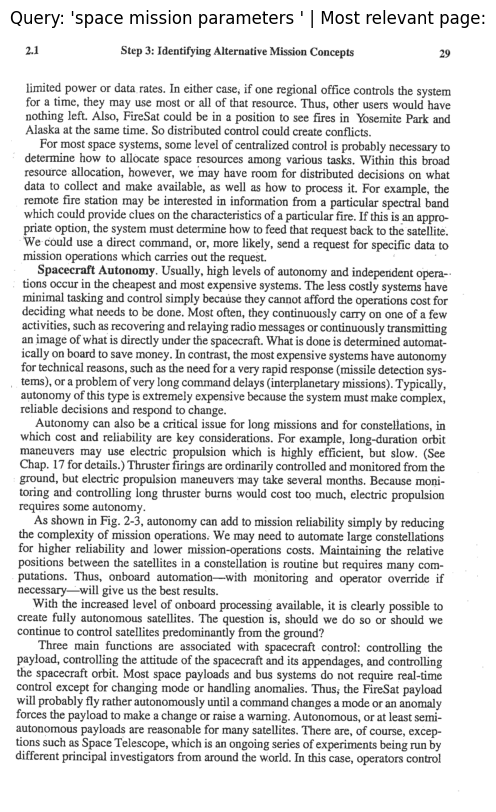

In [254]:
import fitz

# Open PDF and load target page
pdf_path = "/content/Data sets\Space Mission Analysis and Design 3rd Edition (2005).pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(29 + 17) # number of page (our doc starts page numbers on page 17)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [255]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [256]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Excellent! Now let's test our functions out.

In [257]:
query = "space mission parameters "

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1530 embeddings: 0.00008 seconds.


(tensor([145.6341, 142.4786, 139.3321, 137.7242, 137.3024], device='cuda:0'),
 tensor([ 488,  492,  965, 1176,  595], device='cuda:0'))

In [258]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1530 embeddings: 0.00008 seconds.
Query: space mission parameters 

Results:
Score: 145.6341
TABLE 1 02. Spacecraft Subsystems. A spacecraft consists of functional groups of
equipment or subsystems. Subsystem Principal Functions Other Names References
Propulsion Provides thrust to adjust orbit and attitude, and to manage angular
momentum Reaction Control System (BCS) Sec.10.4.1, Chap.17 Attitude
Determination & Control System (ADCS) Provides determination and control of
attitude and orbit position, plus pointing of spacecraft and appendages Aftitude
ControlSystem (ACS) Guidance, Navigation, & Control (GNAq System, Control System
Secs.10.4.2,11.1, 117 Communication (Comm) Communicates with ground & other
spacecraft; spacecraft tracking Tracking, Telemetry, & Command (TT&C)
Secs.10.4.3,11.2 Command & Data Handling (C&DH) Processes and distributes
commands; processes, stores, and formats data Spacecraft Computer System,
Spacecraft Processor Secs.10.4.4, 

### Getting an LLM for local generation

We're got our retrieval pipeline ready, to perform generation, we're going to use a Large Language Model (LLM).

LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output of text given a input of text.

And more specifically, we want the output of text to be generated based on the context of relevant information to the query.


In [259]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [260]:
#change according to the platform we are running our project on
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [261]:
! pip install BitsAndBytes

In [262]:
!pip install flash-attn

In [263]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# For models that require 4-bit quantization
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
model_id = "tiiuae/Falcon3-1B-Instruct"
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: tiiuae/Falcon3-1B-Instruct


In [264]:
llm_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(131072, 2048)
    (layers): ModuleList(
      (0-17): 18 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm

In [265]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1669408768

In [266]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 3338827264, 'model_mem_mb': 3184.15, 'model_mem_gb': 3.11}

In [267]:
input_text = "Explain the key parameters for a space mission, including trajectory design, payload specifications, and scheduling. Provide a step-by-step approach to arranging them."
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "system", "content": "You are SMADAI aerospace engineer in NASA with 25 years of experience in space mission analysis and design."},
    {"role": "user", "content": input_text}
]


# Apply the chat template
prompt = tokenizer.apply_chat_template(
    conversation=dialogue_template,
    tokenize=False,
    add_generation_prompt=True
)

print(f"\nPrompt (formatted):\n{prompt}")

Input text:
Explain the key parameters for a space mission, including trajectory design, payload specifications, and scheduling. Provide a step-by-step approach to arranging them.

Prompt (formatted):
<|system|>
You are SMADAI aerospace engineer in NASA with 25 years of experience in space mission analysis and design.
<|user|>
Explain the key parameters for a space mission, including trajectory design, payload specifications, and scheduling. Provide a step-by-step approach to arranging them.
<|assistant|>



In [268]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to(device)
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(
    inputs=tokenizer(prompt, return_tensors="pt").input_ids.to("cuda"),
    max_length=1024,
    temperature=0.7,  # Controls randomness
    top_k=50,         # Limits sampling to top 50 tokens
    top_p=0.9         # Nucleus sampling
)

print(f"Model output (tokens):\n{outputs[0]}\n")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Model input (tokenized):
{'input_ids': tensor([[  2051,   2115,  12546, 100846,     12,   3675,   2402,  25154,   5939,
           2064,  41494,  16781,   2303,  20219,   2368,   2226,   2041,   2044,
           2951,   2306,   3575,   2303,   4354,   7284,   6068,   2305,   3248,
           2037,     12,   2051,   2115,   5517, 100846,     12,  81885,   2278,
           3687,   9197,   2346,   2265,   4354,   7284,   2035,   3496,  35818,
           3248,   2035,  18272,  18077,   2035,   2305,  22078,   2037,  23687,
           2265,   4234,   2036,   3147,   2036,   9735,   5557,   2302,  37837,
           2679,   2037,     12,   2051,   2115,  91961, 100846,     12]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model ou

In [269]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<|system|>
You are SMADAI aerospace engineer in NASA with 25 years of experience in space mission analysis and design.
<|user|>
Explain the key parameters for a space mission, including trajectory design, payload specifications, and scheduling. Provide a step-by-step approach to arranging them.
<|assistant|>
Certainly! When designing a space mission, several key parameters are crucial for its success. These include trajectory design, payload specifications, and scheduling. Here's a step-by-step approach to arranging these parameters:

### 1. **Mission Objectives and Requirements**
- **Define the Mission:** Clearly outline the goals of the mission, such as scientific objectives, technological advancements, or exploration of a specific celestial body.
- **Mission Profile:** Determine the mission's duration, altitude, and orbit parameters.

### 2. **Trajectory Design**
- **Orbital Mechanics:** Use orbital mechanics to determine the optimal trajectory that maximizes

In [270]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: Explain the key parameters for a space mission, including trajectory design, payload specifications, and scheduling. Provide a step-by-step approach to arranging them.

Output text:
Certainly! When designing a space mission, several key parameters are crucial for its success. These include trajectory design, payload specifications, and scheduling. Here's a step-by-step approach to arranging these parameters:

### 1. **Mission Objectives and Requirements**
- **Define the Mission:** Clearly outline the goals of the mission, such as scientific objectives, technological advancements, or exploration of a specific celestial body.
- **Mission Profile:** Determine the mission's duration, altitude, and orbit parameters.

### 2. **Trajectory Design**
- **Orbital Mechanics:** Use orbital mechanics to determine the optimal trajectory that maximizes scientific return while minimizing fuel consumption.
- **Gravity Assists:** Consider using gravity assists from planets to alter the trajec

In [271]:

gpt4_questions = [
    "What are the space mission parameters, and what roles do they play in the space mission design?",
    "How do space mission parameters and constrains differ in their roles and importance for space mission design?",
    "Describe the process of a complete space mission in a real world.",
    "why do we need to identify our user in a space mission",
    "Explain the concept of energy balance and its importance in weight management during our design."
]

# Manually created question list
manual_questions = [
    "what is the types of mission constrains?",
    "what is the preliminary design",
    "what is optimal trajectories",
    "how to calulate the amount of energy needed for each mission",
    "mission cost analysis parameters"
]

query_list = gpt4_questions + manual_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [272]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: what is the types of mission constrains?
[INFO] Time taken to get scores on 1530 embeddings: 0.00006 seconds.


(tensor([98.7801, 97.2836, 96.5399, 92.5348, 91.2743], device='cuda:0'),
 tensor([ 108,  960,   31,  799, 1033], device='cuda:0'))

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

In [286]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    """
    Augments a query with SMAD-specific context and formats it into a prompt.
    """
    # Join context items into one numbered paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with SMAD-specific examples
    base_prompt = """Based on the following context items, please answer the query.
Extract relevant information from the context and provide a detailed, step-by-step answer.
Focus on precision and clarity in explanations, tailored to space mission analysis and design topics.
Use the following examples as reference for the ideal answer style:

Example 1:
Query: What are the key considerations for designing a satellite trajectory?
Answer: Designing a satellite trajectory involves understanding mission objectives, such as communication, observation, or scientific measurements. Key considerations include orbital mechanics, fuel constraints, and environmental factors like gravitational forces, atmospheric drag, and radiation belts. The process begins by defining mission goals, followed by selecting an optimal orbit type (e.g., geostationary, polar, or sun-synchronous) and iteratively refining parameters like inclination, altitude, and launch window.

Example 2:
Query: How do you determine payload specifications for a deep-space mission?
Answer: Payload specifications for deep-space missions depend on mission objectives and constraints like available power, mass, and volume. Start by identifying the mission’s scientific or operational goals. Then allocate the spacecraft’s mass and power budget across instruments, communication systems, and propulsion. Ensure that instruments meet mission requirements, such as resolution for imaging or sensitivity for sensors. Finally, conduct simulations and trade-off analyses to validate feasibility.

Example 3:
Query: What are the challenges in scheduling space missions?
Answer: Scheduling space missions involves aligning launch windows, spacecraft readiness, and operational timelines with external constraints like planetary alignment, ground station availability, and weather conditions. For interplanetary missions, optimal launch windows depend on Hohmann transfer calculations. Challenges include delays in manufacturing or testing, conflicts with other missions, and unforeseen issues like software anomalies.

Now use the following context items to answer the user query:
{context}

Relevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)
    return prompt


In [287]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How do space mission parameters and constrains differ in their roles and importance for space mission design?
[INFO] Time taken to get scores on 1530 embeddings: 0.00007 seconds.
<|user|>
Based on the following context items, please answer the query.
Extract relevant information from the context and provide a detailed, step-by-step answer.
Focus on precision and clarity in explanations, tailored to space mission analysis and design topics.
Use the following examples as reference for the ideal answer style:
    
Example 1:
Query: What are the key considerations for designing a satellite trajectory?
Answer: Designing a satellite trajectory involves understanding mission objectives, such as communication, observation, or scientific measurements. Key considerations include orbital mechanics, fuel constraints, and environmental factors like gravitational forces, atmospheric drag, and radiation belts. The process begins by defining mission goals, followed by selecting an optimal orbit

In [288]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Query: How do space mission parameters and constrains differ in their roles and importance for space mission design?
RAG answer:
<|user|>
Based on the following context items, please answer the query.
Extract relevant information from the context and provide a detailed, step-by-step answer.
Focus on precision and clarity in explanations, tailored to space mission analysis and design topics.
Use the following examples as reference for the ideal answer style:
    
Example 1:
Query: What are the key considerations for designing a satellite trajectory?
Answer: Designing a satellite trajectory involves understanding mission objectives, such as communication, observation, or scientific measurements. Key considerations include orbital mechanics, fuel constraints, and environmental factors like gravitational forces, atmospheric drag, and radiation belts. The process begins by defining mission goals, followed by selecting an optimal orbit type (e.g., geostationary, polar, or sun-synchronous) an

In [289]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [290]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Query: Describe the process of a complete space mission in a real world.
[INFO] Time taken to get scores on 1530 embeddings: 0.00012 seconds.
Answer:

<|user|> Based on the following context items, please answer the query. Extract
relevant information from the context and provide a detailed, step-by-step
answer. Focus on precision and clarity in explanations, tailored to space
mission analysis and design topics. Use the following examples as reference for
the ideal answer style:      Example 1: Query: What are the key considerations
for designing a satellite trajectory? Answer: Designing a satellite trajectory
involves understanding mission objectives, such as communication, observation,
or scientific measurements. Key considerations include orbital mechanics, fuel
constraints, and environmental factors like gravitational forces, atmospheric
drag, and radiation belts. The process begins by defining mission goals,
followed by selecting an optimal orbit type (e.g., geostationary, polar, 

[{'page_number': 520,
  'sentence_chunk': 'Above all, we should schedule qualification tests to qualify the spacecraft completely before launch. The following sections address these steps and describe important aspects of system design. TABLE 123. Steps in Manufacturing, Integrating, and Testing. Step Description Comments Prepare Engineering Data Complete drawings and all supporting information such as material and oart specifications and processing methods Engineering data will consist of several hundred drawings for each component, specifications for each piecepart type and process, assembly drawings, and test equipment data Manufacture Component Stages: 1 . Manufacture planning 2. Parts procurement and test 3. Component assembly 4. Component acceptance Typical timing: 1. In parallel with engineeringdata preparation 2. Mechanical parts and materials 16 mos ElectroniC parts 318 mos 3.13 mos 4.13mos; acceptancetestincludesfunctional test and environmental exposure Qualify Component Fun

In [291]:
def format_llm_output(query, output, context_items):
    """
    Format the LLM output into a structured, readable format.

    Args:
        query (str): The query asked to the LLM.
        output (str): Raw output from the LLM.
        context_items (list): Contextual information from which relevant sections are extracted.

    Returns:
        None
    """
    print(f"Query: {query}\n")
    print(" Answer:\n")


    print(f"\n{output}\n<|endoftext|>")

In [292]:
query = random.choice(query_list)
output = ask(query=query, temperature=0.7, max_new_tokens=1024)

# Format and print the LLM output
format_llm_output(query, output, context_items)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


[INFO] Time taken to get scores on 1530 embeddings: 0.00006 seconds.
Query: mission cost analysis parameters

 Answer:


<|user|>
Based on the following context items, please answer the query.
Extract relevant information from the context and provide a detailed, step-by-step answer.
Focus on precision and clarity in explanations, tailored to space mission analysis and design topics.
Use the following examples as reference for the ideal answer style:
    
Example 1:
Query: What are the key considerations for designing a satellite trajectory?
Answer: Designing a satellite trajectory involves understanding mission objectives, such as communication, observation, or scientific measurements. Key considerations include orbital mechanics, fuel constraints, and environmental factors like gravitational forces, atmospheric drag, and radiation belts. The process begins by defining mission goals, followed by selecting an optimal orbit type (e.g., geostationary, polar, or sun-synchronous) and iterat